In [3]:
import tensorflow as tf
import os, glob, random
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from collections import defaultdict
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
BASE_DIR     = r"C:\Users\KI\Downloads\A Database of Leaf Images"
IMG_SIZE     = (128, 128)
BATCH_SIZE   = 16
AUTOTUNE     = tf.data.AUTOTUNE

In [5]:
jpg_paths = []
species_counts = defaultdict(int)
species_condition_counts = defaultdict(lambda: defaultdict(int))

for root, _, files in os.walk(BASE_DIR):
    for fname in files:
        if fname.lower().endswith('.jpg'):
            full_path = os.path.join(root, fname)
            jpg_paths.append(full_path)
            
            parts     = os.path.normpath(root).split(os.sep)
            species   = parts[-2]
            condition = parts[-1]
            species_counts[species] += 1
            species_condition_counts[species][condition] += 1

     Path : C:\Users\KI\Downloads\A Database of Leaf Images\Jatropha (P6)\diseased\0018_0097.JPG
  Species : Jatropha (P6)
 Condition : diseased
Image Size : (4000, 6000, 3)


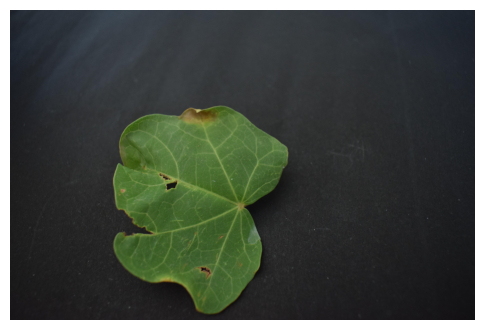

In [6]:
rnd_path  = random.choice(jpg_paths)
cond      = os.path.basename(os.path.dirname(rnd_path))
sp        = os.path.basename(os.path.dirname(os.path.dirname(rnd_path)))
img       = mpimg.imread(rnd_path)

print(f"     Path : {rnd_path}")
print(f"  Species : {sp}")
print(f" Condition : {cond}")
print(f"Image Size : {img.shape}")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.show()

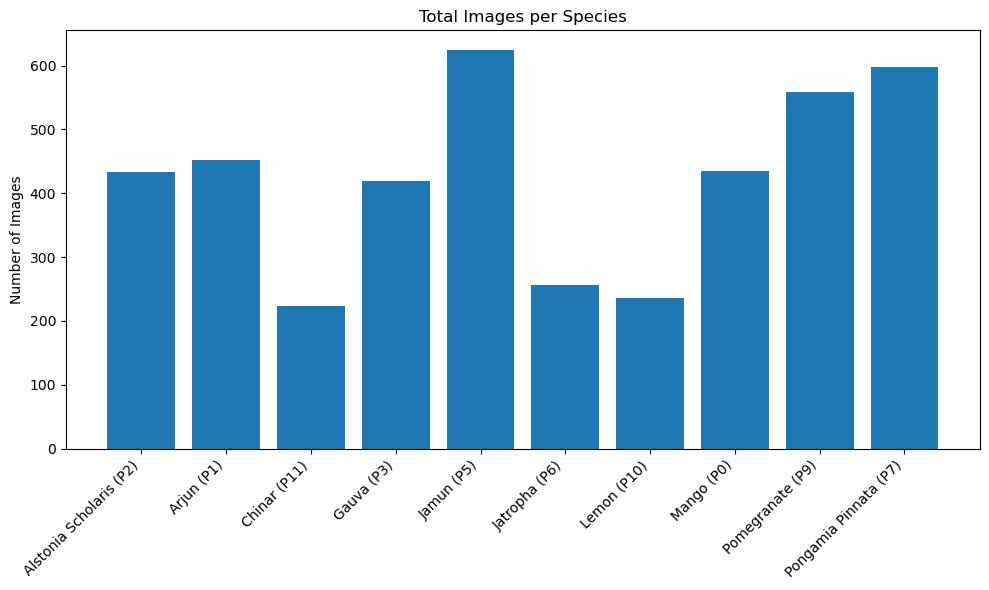

In [7]:
species_list = list(species_counts.keys())
counts       = [species_counts[s] for s in species_list]

plt.figure(figsize=(10,6))
plt.bar(species_list, counts)
plt.title("Total Images per Species")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

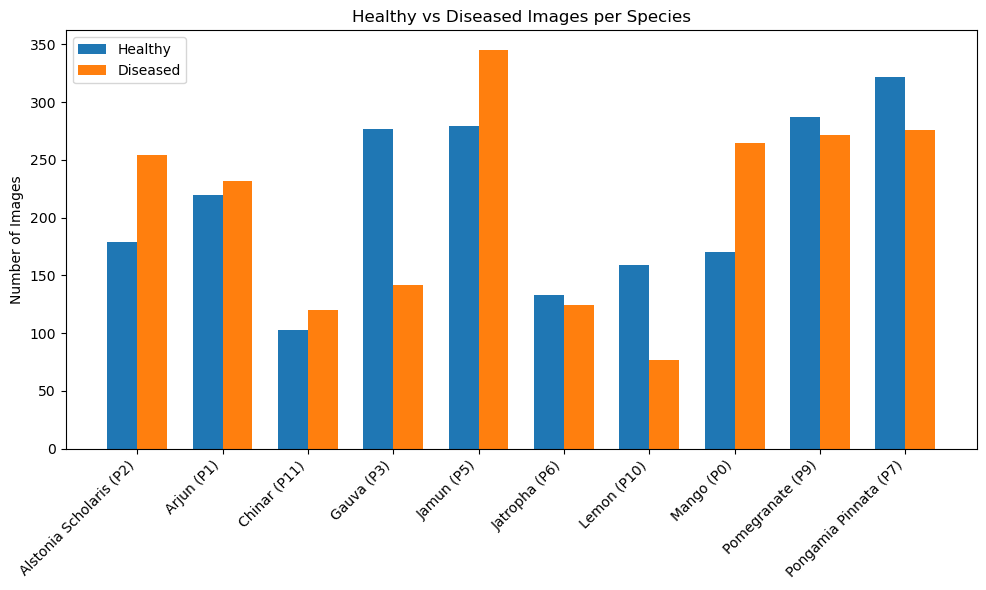

In [8]:
conds = ['healthy','diseased']
data = {c: [species_condition_counts[s].get(c,0) for s in species_list]
        for c in conds}

x     = np.arange(len(species_list))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, data['healthy'],  width, label='Healthy')
plt.bar(x + width/2, data['diseased'], width, label='Diseased')
plt.title("Healthy vs Diseased Images per Species")
plt.ylabel("Number of Images")
plt.xticks(x, species_list, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
all_paths = glob.glob(os.path.join(BASE_DIR, '*', '*', '*.jpg'))

In [10]:
species_list   = sorted(os.listdir(BASE_DIR))
num_species    = len(species_list)
species_to_idx = {sp: i for i, sp in enumerate(species_list)}
health_to_idx  = {'healthy': 0, 'diseased': 1}

In [11]:
train_paths, temp_paths = train_test_split(all_paths, test_size=0.2, random_state=42)
val_paths,   test_paths = train_test_split(temp_paths,   test_size=0.5, random_state=42)

In [12]:
def process_path(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0

    parts = tf.strings.split(path, os.sep)
    species_name = parts[-3].numpy().decode()
    health_name  = parts[-2].numpy().decode()

    species_idx = species_to_idx[species_name]
    health_idx  = health_to_idx[health_name]

    species_label = tf.one_hot(species_idx, num_species)
    health_label  = tf.cast(health_idx, tf.float32)
    
    return img, species_label, health_label

In [13]:
def augment_img(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.7, upper=1.3)
    img = tf.image.random_saturation(img, lower=0.7, upper=1.3)
    k   = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    return img

In [14]:
def tf_process_path(path):
    img, sp, hl = tf.py_function(
        func=process_path,
        inp=[path],
        Tout=[tf.float32, tf.float32, tf.float32]
    )
    img.set_shape((*IMG_SIZE, 3))
    sp.set_shape((num_species,))
    hl.set_shape(())

    return img, {"species": sp, "health": hl}

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths))
            .map(tf_process_path, num_parallel_calls=AUTOTUNE)
            .map(lambda img, labs: (augment_img(img), labs),
           num_parallel_calls=AUTOTUNE) 
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds   = tf.data.Dataset.from_tensor_slices(val_paths)
val_ds   = (val_ds
            .map(tf_process_path, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
          .map(tf_process_path, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE)
)

In [16]:
def build_multi_task(img_size, num_species):
    base = MobileNetV2(
        input_shape=(*img_size,3),
        include_top=False,
        weights='imagenet')

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)

    species_out = Dense(128, activation='relu')(x)
    species_out = Dense(num_species, activation='softmax', name='species')(species_out)

    health_out = Dense(64, activation='relu')(x)
    health_out = Dense(1, activation='sigmoid', name='health')(health_out)

    return Model(inputs=base.input, outputs=[species_out, health_out])

In [17]:
model = build_multi_task(IMG_SIZE, num_species)
model.compile(
    optimizer='adam',
    loss={'species':'categorical_crossentropy',
          'health':'binary_crossentropy'},
    loss_weights={'species':1.0, 'health':0.5},
    metrics={'species':'accuracy','health':'accuracy'}
)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
)

Epoch 1/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 76s 312ms/step - health_accuracy: 0.7645 - health_loss: 0.4982 - loss: 1.2899 - species_accuracy: 0.6708 - species_loss: 1.0408 - val_health_accuracy: 0.6651 - val_health_loss: 1.1349 - val_loss: 5.8838 - val_species_accuracy: 0.5047 - val_species_loss: 5.2266
Epoch 2/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 62s 293ms/step - health_accuracy: 0.8307 - health_loss: 0.3609 - loss: 0.6000 - species_accuracy: 0.8624 - species_loss: 0.4196 - val_health_accuracy: 0.8066 - val_health_loss: 0.4786 - val_loss: 8.3106 - val_species_accuracy: 0.4057 - val_species_loss: 7.9849
Epoch 3/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 62s 294ms/step - health_accuracy: 0.8644 - health_loss: 0.3028 - loss: 0.5044 - species_accuracy: 0.8918 - species_loss: 0.3530 - val_health_accuracy: 0.8090 - val_health_loss: 0.6917 - val_loss: 8.4366 - val_species_accuracy: 0.3679 - val_species_loss: 8.0233
Epoch 4/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 63s 297ms/step - health_accuracy: 0.8518 - health_loss: 0

In [19]:
y_true_sp, y_pred_sp = [], []
y_true_h,  y_pred_h  = [], []

for imgs, labels in test_ds:
    sp_logits, h_logits = model.predict(imgs)
    y_true_sp.extend(tf.argmax(labels['species'],axis=1).numpy())
    y_pred_sp.extend(tf.argmax(sp_logits,axis=1).numpy())
    y_true_h.extend(labels['health'].numpy().astype(int))
    y_pred_h.extend((h_logits>0.5).astype(int).flatten())

y_true_sp = np.array(y_true_sp)
y_pred_sp = np.array(y_pred_sp)
y_true_h  = np.array(y_true_h)
y_pred_h  = np.array(y_pred_h)

print("Species accuracy:", accuracy_score(y_true_sp, y_pred_sp))
print("Species confusion matrix:\n", confusion_matrix(y_true_sp, y_pred_sp))

print("Health accuracy:", accuracy_score(y_true_h, y_pred_h))
print("Health confusion matrix:\n", confusion_matrix(y_true_h, y_pred_h))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [20]:
print("Species classification report:")
print(classification_report(
    y_true_sp,
    y_pred_sp,
    target_names=species_list,
    digits=4
))

print("Health classification report:")
print(classification_report(
    y_true_h,
    y_pred_h,
    target_names=['healthy','diseased'],
    digits=4
))

Species classification report:
                         precision    recall  f1-score   support

Alstonia Scholaris (P2)     0.7937    0.9615    0.8696        52
             Arjun (P1)     0.8776    0.9149    0.8958        47
           Chinar (P11)     1.0000    1.0000    1.0000        19
             Gauva (P3)     0.9773    0.8958    0.9348        48
             Jamun (P5)     0.9683    0.9385    0.9531        65
          Jatropha (P6)     1.0000    0.9310    0.9643        29
            Lemon (P10)     0.9048    0.8261    0.8636        23
             Mango (P0)     0.9231    0.9730    0.9474        37
       Pomegranate (P9)     1.0000    0.8913    0.9425        46
  Pongamia Pinnata (P7)     0.9483    0.9483    0.9483        58

               accuracy                         0.9292       424
              macro avg     0.9393    0.9280    0.9319       424
           weighted avg     0.9347    0.9292    0.9301       424

Health classification report:
              precision   

In [21]:
model.save('leaf_multitask.h5')  

In [22]:
img_path = r"C:\Users\KI\Downloads\istockphoto-1272350475-612x612.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted species: Lemon (P10)  (idx=6)
Predicted health : healthy  (p=0.003)


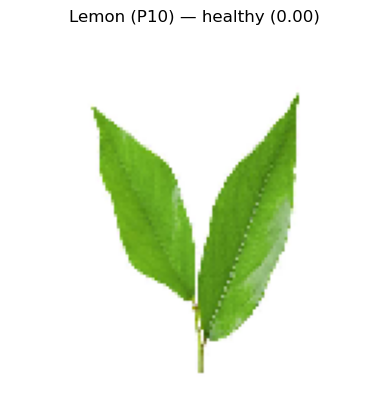

In [23]:
img = image.load_img(img_path, target_size=IMG_SIZE)
x   = image.img_to_array(img) / 255.0
x   = np.expand_dims(x, axis=0)

species_logits, health_logits = model.predict(x)
sp_idx   = np.argmax(species_logits[0])
sp_name  = species_list[sp_idx]
h_prob   = health_logits[0][0]
h_label  = "diseased" if h_prob > 0.5 else "healthy"

print(f"Predicted species: {sp_name}  (idx={sp_idx})")
print(f"Predicted health : {h_label}  (p={h_prob:.3f})")

plt.imshow(img)
plt.title(f"{sp_name} — {h_label} ({h_prob:.2f})")
plt.axis("off")
plt.show()